# 0. Import dependencies

In [1]:
# libraries
import cv2
import numpy as np
import torch
import os
import warnings
warnings.filterwarnings('ignore')
# packages
from python_scripts.swinface_onnx import SwinFaceORT

/home/ipcteam/common/anaconda3/envs/congnt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Face Alignment Phrase


## 1.1 Alignment base opencv

In [2]:
from imutils import face_utils
import argparse
import imutils
import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('src/alignment/shape_predictor_68_face_landmarks.dat')

def rotate(right_eye, left_eye, image):
    midpoint = ((left_eye[0] + right_eye[0]) / 2.0, (left_eye[1] + right_eye[1]) / 2.0)
    angle = np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]) * 180 / np.pi
    midpoint = tuple(midpoint)
    rotation_matrix = cv2.getRotationMatrix2D(midpoint, angle, scale=1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image,rotation_matrix
def rotate_point(point,rotation_matrix):
    # Convert coordinates to NumPy arrays for convenience
    point = np.array(point)

    # Add a row [0, 0, 1] to represent homogeneous coordinates
    point_homogeneous = np.append(point, 1)

    # Apply the rotation matrix
    rotated_point_homogeneous = np.dot(rotation_matrix, point_homogeneous)

    # Convert back to coordinates without homogeneous coordinates
    rotated_point = rotated_point_homogeneous[:2]

    return tuple(map(int, rotated_point))

In [3]:
def alignment_opencv(image):
    rect = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    # if detector more than one face
    if len(rects) !=1 :
        return None
    shape = predictor(gray, rects[0])
    x1, y1 = rects[0].left(), rects[0].top()
    x2, y2 = rects[0].right(), rects[0].bottom()
    shape = face_utils.shape_to_np(shape)
    right_eye = shape[25]
    left_eye = shape[20]
    rotate_img= rotate(right_eye,left_eye,image)
    right_eye = shape[25]
    left_eye = shape[20]
    rotate_img,rotate_matrix = rotate(right_eye,left_eye,image)
    x_max = shape[0][0]
    y_max = shape[0][1]
    x_min = shape[0][0]
    y_min = shape[0][1]
    for (x,y) in shape:
        (x,y) = rotate_point((x,y),rotate_matrix)
        if x_max < x:
            x_max = x
        elif x_min > x:
            x_min = x
        elif y_max < y:
            y_max = y
        elif y_min > y:
            y_min = y
    crop_img = rotate_img[y_min-220:y_max+85,x_min-106:x_max+106]
    print(crop_img.shape)
    return crop_img


In [4]:
path_img = 'test_images/hieuthu2.png'
img = cv2.imread(path_img)
alignment_img = alignment_opencv(img)
cv2.imwrite("img/alignment_hieu.jpg",alignment_img)

(606, 606, 3)


True

## 1.2 Alignment base Star (HairFastGan)

# 2. Face Analysis Phrase

## 2.1. Init parameters

## 2.2. Create/load swin-face model

In [6]:
# create_swinface_model
# def create_swinface_model(cfg, weight_path):
#     model = build_model(cfg)
#     dict_checkpoint = torch.load(weight_path)
#     model.backbone.load_state_dict(dict_checkpoint["state_dict_backbone"])
#     model.fam.load_state_dict(dict_checkpoint["state_dict_fam"])
#     model.tss.load_state_dict(dict_checkpoint["state_dict_tss"])
#     model.om.load_state_dict(dict_checkpoint["state_dict_om"])

#     model.eval()
#     return model 

# weight_path = "src/swinface_project/checkpoint_step_79999_gpu_0.pt"
# swin_face_model = create_swinface_model(cfg, weight_path)
swin_face_onnx_model = SwinFaceORT("onnx_models", cpu=False)

## 2.3. Inference on one image

In [7]:
@torch.no_grad()
def inference(model, img):
    if img is None:
        img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.uint8)
    else:

        img = cv2.resize(img, (112, 112))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float()
    img.div_(255).sub_(0.5).div_(0.5)
    
    output = model(img)

    return output["Recognition"].numpy()

input_image = cv2.cvtColor(cv2.imread("img/alignment_hieu.jpg"), cv2.COLOR_BGR2RGB)
# facial_embedding = inference(swin_face_model, input_image)
swin_face_onnx_model.check()
facial_embeedding_onnx = swin_face_onnx_model.forward(input_image)
print(facial_embeedding_onnx.shape)
# facial_embedding

use onnx-model: onnx_models/swinface.onnx
input-shape: ['None', 3, 112, 112]
3130 [1, 1]
3136 [1, 2]
3137 [1, 2]
3138 [1, 2]
3139 [1, 2]
3128 [1, 2]
3140 [1, 2]
3141 [1, 2]
3134 [1, 2]
3131 [1, 2]
3143 [1, 2]
3144 [1, 2]
3145 [1, 2]
3146 [1, 2]
3147 [1, 2]
3148 [1, 2]
3149 [1, 2]
3150 [1, 2]
3151 [1, 2]
3152 [1, 2]
3154 [1, 2]
3155 [1, 2]
3156 [1, 2]
3157 [1, 2]
3158 [1, 2]
3160 [1, 2]
3161 [1, 2]
3163 [1, 2]
3164 [1, 2]
3165 [1, 2]
3166 [1, 2]
3168 [1, 2]
3169 [1, 2]
3170 [1, 2]
3171 [1, 2]
3172 [1, 2]
3173 [1, 2]
3175 [1, 2]
3176 [1, 2]
3178 [1, 2]
3179 [1, 2]
3133 [1, 7]
2570 [1, 512]
0 Identity_0
1 Identity_1
2 /backbone/patch_embed/proj/Constant
3 /backbone/patch_embed/proj/Conv
4 /backbone/patch_embed/Constant
5 /backbone/patch_embed/Shape
6 /backbone/patch_embed/Constant_1
7 /backbone/patch_embed/Constant_2
(1, 512)


## 2.4. Inference on images

In [8]:
# facial embedding for all images in directory (jpg and png)
def inference_in_dir_path(swin_face_onnx_model, dir_path):
    files = os.listdir(dir_path)
    files = [f for f in files if f.endswith(".jpg") or f.endswith(".png")]

    embeddings = []
    for f in files:
        img = cv2.imread(os.path.join(dir_path, f))
        facial_embedding = swin_face_onnx_model.forward(img)
        embeddings.append(facial_embedding)

    return files, np.concatenate(embeddings, axis=0)

dir_path = "input"
database_path = "database"
list_of_image, embeddings = inference_in_dir_path(swin_face_onnx_model, dir_path)
# convert to nympy file
np.save(os.path.join(database_path, "db.npy"), embeddings)
print(list_of_image)
embeddings.shape

['3.jpg', '0.png', '6.png', 'alignment_hieu.jpg', '1.png', '8.png', '7.png', '4.jpg', '5.jpg', '2.png']


(10, 512)

In [9]:
# import json
# def convert_imgs_to_db(img_dir, db_dir, swinface):
#     files = os.listdir(img_dir)
#     files = [f for f in files if f.endswith(".jpg") or f.endswith(".png")]

#     image_db = []
#     embbedings_db = []
#     metadata = {}
#     img_db_path = os.path.join(db_dir, "img_db.npy")
#     embbedings_db_path = os.path.join(db_dir, "embeddings_db.npy")
#     metadata_path = os.path.join(db_dir, "metadata.txt")
#     for f in files:
#         img = cv2.imread(os.path.join(img_dir, f))
#         facial_embedding = inference(swin_face_model, img)
#         embbedings_db.append(facial_embedding)
#         image_db.append(img)
#         id = files.index(f)
#         info = {'name': f}
#         metadata[str(id)] = info

#     np.save(embbedings_db_path, np.array(embbedings_db))
#     np.save(img_db_path, np.array(image_db))
#     # save json file
#     with open(metadata_path, 'w') as outfile:
#         json.dump(metadata, outfile)
        
# dir_path = "input"
# database_path = "database"
# convert_imgs_to_db(dir_path, database_path, swin_face_model)

In [10]:
import json
import os
import numpy as np

def load_db(db_dir):
    image_db_path = os.path.join(db_dir, "img_db.npy")
    embbedings_db_path = os.path.join(db_dir, "embeddings_db.npy")
    metadata_path = os.path.join(db_dir, "metadata.txt")
    image_db = np.load(image_db_path, allow_pickle=True)
    embbedings_db = np.load(embbedings_db_path, allow_pickle=True)
    with open(metadata_path) as json_file:
        metadata = json.load(json_file)
    return image_db, embbedings_db, metadata

database_path = "database"
image_db, embbedings_db, metadata = load_db(database_path)

## 2.5. Caculate the cosine similarity between two embedding

In [11]:
# caculate similarity between 2 embeddings (numpy array)
def distance(embedding1, embedding2):
        embedding1, embedding2 = embedding1.squeeze(), embedding2.squeeze()
        return 1- np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    
# cosine_distance = distance(facial_embedding, facial_embeedding_onnx)
# print(cosine_distance)

In [12]:


# caculate similarity between embeddings and a specific embedding
def distance_with_specific_embedding(embedding_1, embeeings_db):
    list_of_dist = []
    for embedding_2 in embeeings_db:
        list_of_dist.append(distance(embedding_1, embedding_2))
    return np.array(list_of_dist)
    
list_of_dist = distance_with_specific_embedding(facial_embeedding_onnx, embbedings_db)
list_of_dist
print(min(list_of_dist))

0.04809945821762085


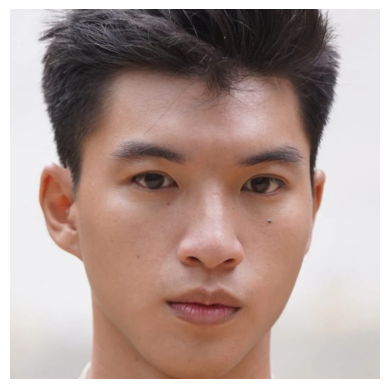

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

dir_path = "input"
best_suitable_image_path = os.path.join(dir_path, list_of_image[np.argmin(list_of_dist)])
best_suitable_image = cv2.cvtColor(cv2.imread(best_suitable_image_path), cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(best_suitable_image)
plt.show()

# 3. Hair Swap Phrase using HairFastGAN

In [17]:
import argparse
from pathlib import Path

import sys

from python_scripts.hair_swap import HairFast, get_parser

model_args = get_parser()
hair_fast = HairFast(model_args.parse_args([]))

FileNotFoundError: [Errno 2] No such file or directory: 'pretrained_models/StyleGAN'

In [ ]:
import requests
from io import BytesIO
from PIL import Image
from functools import cache

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as T
import torch
%matplotlib inline


def to_tuple(func):
    def wrapper(arg):
        if isinstance(arg, list):
            arg = tuple(arg)
        return func(arg)
    return wrapper


@to_tuple
@cache
def download_and_convert_to_pil(urls):
    pil_images = []
    for url in urls:
        response = requests.get(url, allow_redirects=True, headers={"User-Agent": "Mozilla/5.0"})
        img = Image.open(BytesIO(response.content))
        pil_images.append(img)
        print(f"Downloaded an image of size {img.size}")
    return pil_images


def display_images(images=None, **kwargs):
    is_titles = images is None
    images = images or kwargs

    grid = gridspec.GridSpec(1, len(images))
    fig = plt.figure(figsize=(20, 10))

    for i, item in enumerate(images.items() if is_titles else images):
        title, img = item if is_titles else (None, item)

        img = T.functional.to_pil_image(img) if isinstance(img, torch.Tensor) else img
        img = Image.open(img) if isinstance(img, str | Path) else img

        ax = fig.add_subplot(1, len(images), i+1)
        ax.imshow(img)
        if title:
            ax.set_title(title, fontsize=20)
        ax.axis('off')

    plt.show()

In [ ]:
import numpy as np

input_dir = Path('input')
face_path = input_dir / '0.png'
shape_path =  input_dir / '2.png'
color_path = input_dir / '1.png'

final_image, face_align, shape_align, color_align = hair_fast.swap(face_path, shape_path, color_path, align=True)
# T.functional.to_pil_image(final_image).resize((512, 512))  # 1024 -> 512
display_images(result=final_image, face=face_align, shape=shape_align, color=color_align)

Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1


KeyError: 'ACE'